# Case Study: Credit Card Approvals

## The Scene
You are a Data Scientist at a bank. You have a historical dataset of credit card applications. Some were **Approved (+)**, others were **Rejected (-)**.

Your boss asks: *"Can we visualize our customer base? Are the approved customers distinct from the rejected ones, or is it all mixed up?"*

Since the data is high-dimensional (Age, Debt, BankCustomer, Employment, etc.), you can't just plot `x` vs `y`. You need a way to map this high-dimensional data onto a 2D map.

**Enter the Self-Organizing Map (SOM).**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle

## 1. The Data Pipeline
Real-world data is messy. We are using the **UCI Credit Approval Dataset**.
- **Confidential**: All attribute names and values have been changed to meaningless symbols to protect user privacy.
- **Noisy**: It contains missing values (`?`) and a mix of numbers and text.

In [2]:
# Download and Load Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
dataset = pd.read_csv(url, header=None)

# De-anonymize columns for educational clarity
# Mapping based on common UCI dataset interpretations
columns = ["Gender", "Age", "Debt", "Married", "BankCustomer", "EducationLevel", "Ethnicity", "YearsEmployed", "PriorDefault", "Employed", "CreditScore", "DriversLicense", "Citizen", "ZipCode", "Income", "Approved"]
dataset.columns = columns

# Peek at the mess
dataset.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


### Data Cleaning
1.  **Missing Values**: The dataset uses `?` for missing info. We replace them with `NaN` and then impute (fill) them.
    - **Numerical Columns**: Fill with the **Mean**.
    - **Categorical Columns**: Fill with the **Mode** (Most frequent value).
2.  **Encoding**: Computers need numbers. We use `LabelEncoder` to turn text categories (e.g., 'u', 'y', 'l') into numbers (0, 1, 2...).

In [3]:
# 1. Handle '?'
dataset = dataset.replace('?', np.nan)

# Data Type Correction: Ensure numeric columns are actually numeric
for col in dataset.columns:
    # Try to convert to numeric, but keep as object if it fails (safe replacement for errors='ignore')\n    try:\n        dataset[col] = pd.to_numeric(dataset[col])\n    except (ValueError, TypeError):\n        pass\n
# 2. Impute Missing Values
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
    else:
        # Use mean for numerical columns
        dataset[col] = dataset[col].fillna(dataset[col].mean())

# 3. Check for any remaining nulls
print("Remaining nulls:", dataset.isnull().sum().sum())

Remaining nulls: 0


/var/folders/fv/1glf1w45215d_trl8514hbnr0000gp/T/ipykernel_69775/1222678758.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset[col] = pd.to_numeric(dataset[col], errors='ignore')


In [4]:
# 4. Encode Categorical Data
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = le.fit_transform(dataset[col])

dataset.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,0,12,7,1.25,1,1,1,0,0,202.0,0,0
1,0,58.67,4.460,1,0,10,3,3.04,1,1,6,0,0,43.0,560,0
2,0,24.50,0.500,1,0,10,3,1.50,1,0,0,0,0,280.0,824,0
3,1,27.83,1.540,1,0,12,7,3.75,1,1,5,1,0,100.0,3,0
4,1,20.17,5.625,1,0,12,7,1.71,1,0,0,0,2,120.0,0,0


### Feature Extraction & Scaling
- **X**: All columns except the last one (Attributes).
- **y**: The last column (Approved/Rejected).
- **Scaling**: SOMs use distance (Euclidean). We strictly scale everything to 0-1.

In [5]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X = sc.fit_transform(X)
print(f"Data Scaled. X shape: {X.shape}")

Data Scaled. X shape: (690, 15)


## 2. The Model (SOM)
We reuse our robust `SimpleSOM` class.

In [6]:
class SimpleSOM:
    def __init__(self, x, y, input_len):
        self.x = x
        self.y = y
        self.input_len = input_len
        self.weights = np.random.random((x, y, input_len))
        self.learning_rate = 0.5
        self.radius = max(x, y) / 2
        self.time_constant = 1.0 

    def find_winner(self, sample):
        diff = self.weights - sample
        sq_dist = np.sum(diff**2, axis=2)
        return np.unravel_index(np.argmin(sq_dist), (self.x, self.y))

    def update_weights(self, sample, winner, iteration):
        rad = self.radius * np.exp(-iteration / self.time_constant)
        lr = self.learning_rate * np.exp(-iteration / self.time_constant)
        
        if rad < 1e-10: rad = 1e-10

        for i in range(self.x):
            for j in range(self.y):
                dist = np.sqrt((i - winner[0])**2 + (j - winner[1])**2)
                if dist <= rad:
                    influence = np.exp(-(dist**2) / (2 * (rad**2)))
                    self.weights[i, j] += lr * influence * (sample - self.weights[i, j])

    def train(self, data, num_epochs):
        total_steps = len(data) * num_epochs
        self.time_constant = total_steps / np.log(self.radius)
        
        step = 0
        for epoch in range(num_epochs):
            np.random.shuffle(data)
            for sample in data:
                winner = self.find_winner(sample)
                self.update_weights(sample, winner, step)
                step += 1

    def distance_map(self):
        dmap = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                neighbors = []
                if i > 0: neighbors.append(self.weights[i-1, j])
                if i < self.x-1: neighbors.append(self.weights[i+1, j])
                if j > 0: neighbors.append(self.weights[i, j-1])
                if j < self.y-1: neighbors.append(self.weights[i, j+1])
                if len(neighbors) > 0:
                    dists = [np.linalg.norm(self.weights[i, j] - n) for n in neighbors]
                    dmap[i, j] = np.mean(dists)
        return (dmap - dmap.min()) / (dmap.max() - dmap.min())

## 3. Training
We use a **10x10 Grid**. This provides 100 distinctive "Customer Archetypes".

In [7]:
som = SimpleSOM(10, 10, X.shape[1])
som.train(X, num_epochs=100)
print("Training Complete")

Training Complete


## 4. Visualization: Approved vs Rejected
We map the customers back to the grid.
- **Green Squares**: Approved Customers (+)
- **Red Circles**: Rejected Customers (-)

**Hypothesis**: If the machine learning works, the Green Squares and Red Circles should occupy different territories on the map.

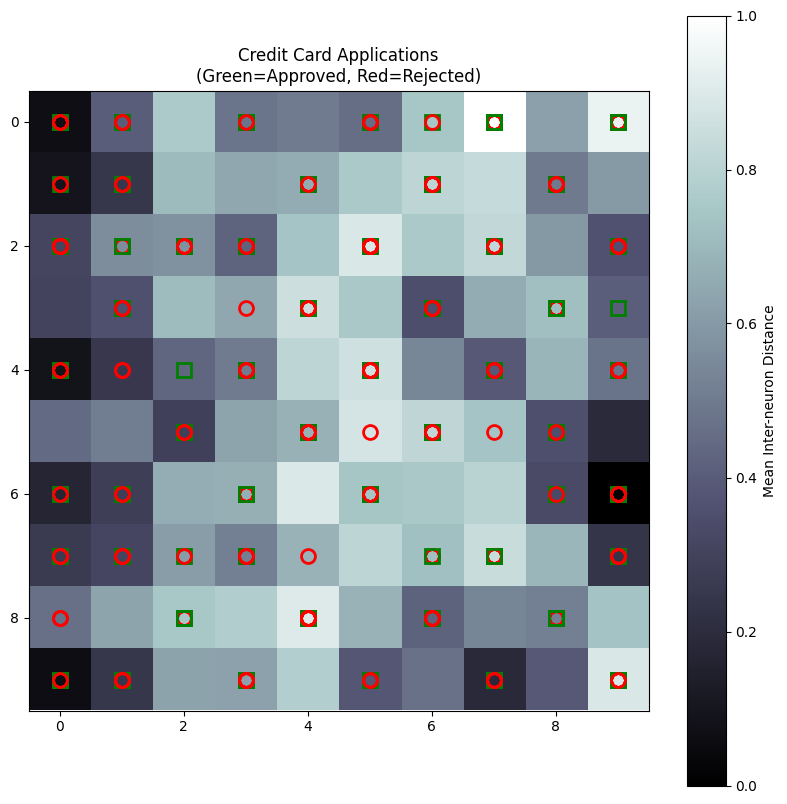

In [8]:
plt.figure(figsize=(10, 10))

# 1. Distance Map (Background)
plt.imshow(som.distance_map(), cmap='bone', interpolation='none')
plt.colorbar(label='Mean Inter-neuron Distance')

# 2. Plotting Markers
# We handle the mapping explicitly because LabelEncoder might assign 0/1 arbitrarily
try:
    pos_code = le.transform(['+'])[0]
except:
    pos_code = 0 # Fallback if '+' not found (unlikely)

for i, x in enumerate(X):
    w = som.find_winner(x)
    
    if y[i] == pos_code:
        # Approved -> Green Square
        m = 's'
        c = 'g'
    else:
        # Rejected -> Red Circle
        m = 'o'
        c = 'r'
    
    plt.plot(w[1], w[0],
             m,
             markeredgecolor=c,
             markerfacecolor='None',
             markersize=10,
             markeredgewidth=2)

plt.title('Credit Card Applications\n(Green=Approved, Red=Rejected)')
plt.show()

## 5. Interactive Feature Analysis
To understand **why** certain areas are approved or rejected, we can visualize the distribution of specific features across the map. 

Select a feature below (e.g., `Income`, `Debt`, `YearsEmployed`) to see where high values are clustered.

In [9]:
import ipywidgets as widgets
from ipywidgets import interact

def plot_feature_map(feature_name):
    # Find the column index in X
    # Note: dataset has 'Approved' at the end, X does not include it.
    feature_idx = list(dataset.columns[:-1]).index(feature_name)
    
    # Calculate average feature value for each neuron
    feature_map = np.zeros((som.x, som.y))
    counts = np.zeros((som.x, som.y))
    
    for i, x in enumerate(X):
        w = som.find_winner(x)
        # The value is scaled (0-1), which is good for visualization consistency
        val = X[i, feature_idx] 
        feature_map[w] += val
        counts[w] += 1
        
    # Avoid division by zero
    feature_map = np.divide(feature_map, counts, out=np.zeros_like(feature_map), where=counts!=0)
    
    plt.figure(figsize=(6, 6))
    plt.title(f"SOM Heatmap: {feature_name}\n(Yellow=High, Purple=Low)")
    plt.imshow(feature_map, cmap='viridis', interpolation='none')
    plt.colorbar(label='Feature Value (Scaled 0-1)')
    plt.show()

print("Explore what defines each cluster:")
interact(plot_feature_map, feature_name=dataset.columns[:-1]);

Explore what defines each cluster:


interactive(children=(Dropdown(description='feature_name', options=('Gender', 'Age', 'Debt', 'Married', 'BankC…

## 6. "Will I Get Approved?" Simulator
Test your luck! Enter numerical details for a hypothetical applicant. 
- We will map this new person onto the grid.
- **Gold Star**: Your position.
- If you land in a "Green Square" region, you are likely **Approved**.

In [10]:
print("Rate a New Applicant:")

style = {'description_width': 'initial'}

# Widgets for key numerical features
# Note: Ranges are approximate based on dataset analysis
w_age = widgets.FloatSlider(value=30.0, min=15.0, max=80.0, step=1.0, description='Age:', style=style)
w_debt = widgets.FloatSlider(value=5.0, min=0.0, max=30.0, step=0.1, description='Debt:', style=style)
w_years = widgets.FloatSlider(value=2.0, min=0.0, max=20.0, step=0.1, description='Years Emp:', style=style)
w_income = widgets.FloatSlider(value=1000.0, min=0.0, max=10000.0, step=100.0, description='Income:', style=style)
w_score = widgets.FloatSlider(value=1.0, min=0.0, max=20.0, step=1.0, description='Credit Score:', style=style)

btn = widgets.Button(description="Map Me!", button_style='success')
out = widgets.Output()

def map_new_applicant(b):
    with out:
        out.clear_output()
        
        # 1. Create a baseline vector (average applicant)
        # Since X is already scaled, we take the mean of the SCALED data
        avg_applicant_scaled = np.mean(X, axis=0)
        
        # 2. Unscale it to get original units (approx) so we can modify it with Slider values
        # shape needed for inverse_transform is (1, 15)
        avg_applicant_original = sc.inverse_transform([avg_applicant_scaled])[0]
        
        # 3. Update with User Input
        # We need to know indices: Age(1), Debt(2), YearsEmployed(7), CreditScore(10), Income(14)
        # These mappings correspond to our 'columns' list defined earlier.
        
        new_data = avg_applicant_original.copy()
        new_data[1] = w_age.value       # Age
        new_data[2] = w_debt.value      # Debt
        new_data[7] = w_years.value     # YearsEmployed
        new_data[10] = w_score.value    # CreditScore
        new_data[14] = w_income.value   # Income

        # 4. Scale it back
        final_vector_scaled = sc.transform([new_data])[0]
        
        # 5. Find Winner
        winner = som.find_winner(final_vector_scaled)
        
        # 6. Plot
        plt.figure(figsize=(6, 6))
        # Background
        plt.imshow(som.distance_map(), cmap='bone', interpolation='none')
        
        # Plot existing approved/rejected (lighter alpha to emphasize the new one)
        for i, x in enumerate(X):
            w = som.find_winner(x)
            if y[i] == pos_code: # Approved
                plt.plot(w[1], w[0], 's', markeredgecolor='g', markerfacecolor='None', alpha=0.1)
            else: # Rejected
                plt.plot(w[1], w[0], 'o', markeredgecolor='r', markerfacecolor='None', alpha=0.1)
        
        # Plot YOU (Gold Star)
        plt.plot(winner[1], winner[0], '*', markeredgecolor='gold', markerfacecolor='gold', markersize=20, label='YOU')
        plt.legend()
        plt.title("Your Position on the Credit Map")
        plt.show()

btn.on_click(map_new_applicant)

display(w_age, w_debt, w_years, w_score, w_income, btn, out)

Rate a New Applicant:


FloatSlider(value=30.0, description='Age:', max=80.0, min=15.0, step=1.0, style=SliderStyle(description_width=…

FloatSlider(value=5.0, description='Debt:', max=30.0, style=SliderStyle(description_width='initial'))

FloatSlider(value=2.0, description='Years Emp:', max=20.0, style=SliderStyle(description_width='initial'))

FloatSlider(value=1.0, description='Credit Score:', max=20.0, step=1.0, style=SliderStyle(description_width='i…

FloatSlider(value=1000.0, description='Income:', max=10000.0, step=100.0, style=SliderStyle(description_width=…

Button(button_style='success', description='Map Me!', style=ButtonStyle())

Output()